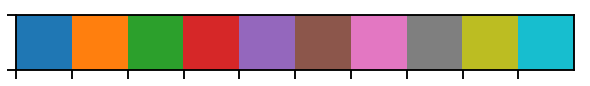

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import edward as ed
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
import numpy as np
import six
import tensorflow as tf

plt.style.use('seaborn-talk')
sns.set_context('talk', font_scale=1.4)
sess = ed.get_session()
sns.palplot(sns.color_palette())

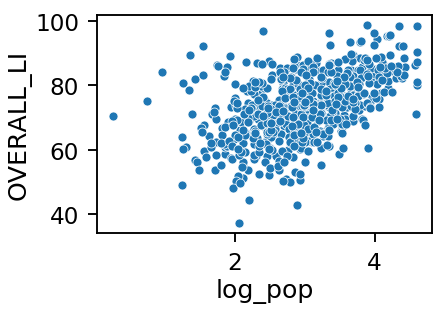

In [4]:
df = pd.read_csv('data/education_india/2015_16_Districtwise.csv')
df['POP_DEN'] = df['TOTPOPULAT']/df['AREA_SQKM']
cols = ['TOTPOPULAT', 'P_URB_POP', 'POPULATION_0_6', 'GROWTHRATE', 'SEXRATIO', 'P_SC_POP', 'P_ST_POP', 'OVERALL_LI',
                'FEMALE_LIT', 'MALE_LIT', 'AREA_SQKM', 'POP_DEN']
df_sub = df[cols].dropna()
df_sub = df_sub[df_sub.P_URB_POP > 0]
df_sub['log_pop'] = np.log(df_sub.P_URB_POP)
df_sub = df_sub.dropna()
sns.scatterplot(x='log_pop', y='OVERALL_LI', data=df_sub)

# Bayesian Machine Learning with Edward

How is South India fairing wrt North India in Overall Literacy? Is it divergent?
South India - ['ANDHRA PRADESH', 'KARNATAKA', 'GOA', 'LAKSHADWEEP', 'KERALA',
       'TAMIL NADU', 'PUDUCHERRY', 'A & N ISLANDS', 'TELANGANA']
1. Posit a Generative model - Start with simple story on how data is generated: Forward direction
2. Infer the model parameters - Infer specifics about story based on observations: Backward direction
3. Criticize the model - Can the simple story explain the observations? Can we improve the story?

Follow this process in a loop

Take n random samples (districts) from both and find difference of each sample. Find probability distribution that reflects that data

In [3]:
si_states = ['ANDHRA PRADESH', 'KARNATAKA', 'GOA', 'LAKSHADWEEP', 'KERALA',
       'TAMIL NADU', 'PUDUCHERRY', 'A & N ISLANDS', 'TELANGANA']
df_si = df[df.STATNAME.isin(si_states)]
df_ni = df[~df.STATNAME.isin(si_states)]
lit_diff = df_si.OVERALL_LI.dropna().sample(n=100).reset_index(drop=True) - df_ni.OVERALL_LI.dropna().sample(n=100).reset_index(drop=True)
lit_abs = np.asarray(1*(lit_diff>0)).astype('int32')

Generative Model:

    p(params, data) = p(params) * p(data|params)

    params: parameters expressing the probability distribution of lit_diff

    data: lit_diff

    p(params): prior probability of lit_diff being represented by params given

    p(data|params): conditional probability that data is observed given the lit_diff is defined by the probability distribution

    p(params, data): Joint probability that both the data is ovserved and the lit_diff is represented by the prob dist

In [4]:
N = 100
from edward.models import Bernoulli, Beta, Empirical, Uniform, Normal

Now we need to infer. Infer what?

Inference is identifying which parameters yield simulated data that is consistent with observed data.
Inference allows for going in the backward direction

Expressed in terms of probability distributions:

    p(params | data = obs) <-- conditioning -- p(params, data), obs

This is the backwards direction.
obs: Fixed realization of data, i.e, list_abs

p(params|data=obs): Posterior conditional distribution of the data given a fixed observation. This is what we are interested in.

Any statistical question we can ask has to come down to a manipulation of the posterior!

In [5]:
fair = Beta(concentration1=1000.0, concentration0=1000.0) # blue
unfair = Beta(concentration1=0.1, concentration0=0.1) # orange
unknown = Beta(concentration1=1., concentration0=1.) # green

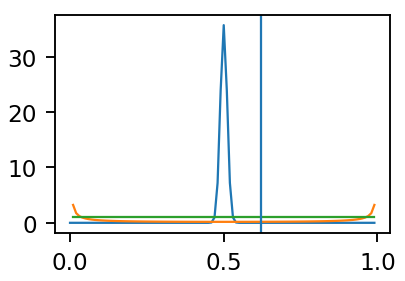

In [12]:
x = tf.range(0.0, 1.0, 0.01)
plt.plot(*sess.run([x, fair.prob(x)]))
plt.plot(*sess.run([x, unfair.prob(x)]))
plt.plot(*sess.run([x, unknown.prob(x)]))
plt.axvline(sum(lit_abs==1)/float(lit_abs.shape[0]))

In [7]:
# Forward model
prior = unknown
c = Bernoulli(probs=prior, sample_shape = N)

In [8]:
# Inference
cond = ed.complete_conditional(prior)
lit_abs_post = ed.copy(cond, {c:lit_abs})

In [9]:
sess.run({k:v for k, v in six.iteritems(lit_abs_post.parameters) if isinstance(v, tf.Tensor)})

{'concentration0': 39.0, 'concentration1': 63.0}

In [11]:
# criticism
mean, stddev = sess.run([lit_abs_post.mean(), lit_abs_post.stddev()])
print('Posterior Mean: {0}\nPosterior Std: {1}'.format(mean, stddev))

Posterior Mean: 0.617647051811
Posterior Std: 0.0478832684457


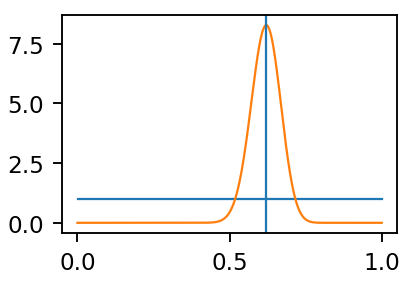

In [13]:
x = tf.range(0., 1., 0.001)
plt.plot(*sess.run([x, prior.prob(x)]))
plt.plot(*sess.run([x, lit_abs_post.prob(x)]))
plt.axvline(x=sum(lit_abs==1)/float(lit_abs.shape[0]))

### MCMC: Metropolis Hastings

In [14]:
# Backward Model
T = 10000 # number of empirical examples
q_lit_abs = Empirical(params=tf.Variable(tf.ones([T])*.5))

In [15]:
# Inference
p_lit_abs = Beta(concentration1=1.0, concentration0=1.0)
inference = ed.MetropolisHastings(latent_vars={prior:q_lit_abs}, proposal_vars={prior:p_lit_abs}, data={c:lit_abs})
inference.run()

/home/a635137/.local/lib/python2.7/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/home/a635137/.local/lib/python2.7/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


10000/10000 [100%] ██████████████████████████████ Elapsed: 5s | Acceptance Rate: 0.158


In [16]:
# Criticism
mean, stddev = sess.run([q_lit_abs.mean(), q_lit_abs.stddev()])
print('Posterior Mean: {0}\nPosterior Std: {1}'.format(mean, stddev))

Posterior Mean: 0.617915987968
Posterior Std: 0.0466866120696


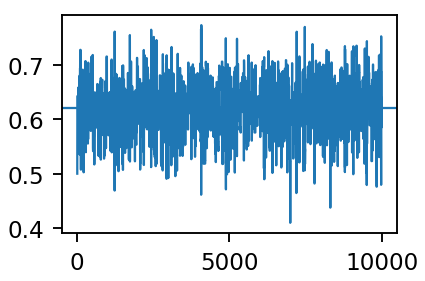

In [17]:
plt.plot(q_lit_abs.params.eval())
plt.axhline(y=sum(lit_abs==1)/float(lit_abs.shape[0]))

In [18]:
def lags(x):
    mean = tf.reduce_mean(x)
    var = tf.cast(tf.size(x) - 1, tf.float32) * tf.reduce_mean(tf.square(x - mean))
    ret = tf.map_fn(lambda k: tf.cond(tf.equal(k, 0),
                                      lambda: var,
                                      lambda: tf.reduce_sum((x[:-k] - mean) * (x[k:] - mean))),
                    tf.range(0, tf.size(x)),
                    dtype=tf.float32)
    return ret / var

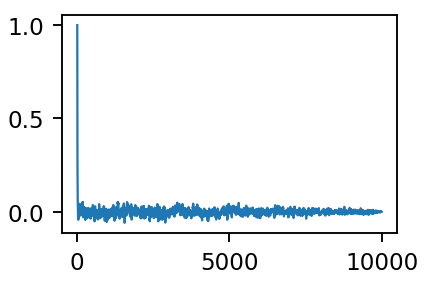

In [20]:
plt.plot(lags(q_lit_abs.params).eval())

/home/a635137/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


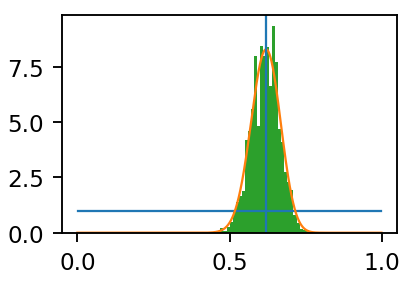

In [21]:
x = tf.range(0.0, 1.0, 0.001)
true_prob = sum(lit_abs==1)/float(lit_abs.shape[0])
plt.plot(*sess.run([x, prior.prob(x)]))  # blue flat line
plt.plot(*sess.run([x, cond.prob(x)], {c: lit_abs})) # orange
plt.hist(q_lit_abs.params.eval(), bins=100, range=(0.0, 1.0), normed=True) # green
plt.axvline(x=true_prob) # blue vertical

### MCMC: Gibbs Sampling

Special case of Metropolis Hastings. -> Proposal for a parameter is drawn from its complete conditiona, ie, the distribution of that parameter conditioned on the current values of all other parameters

In [35]:
# Backward Model
T = 10000 # number of empirical examples
q_lit_abs = Empirical(params=tf.Variable(tf.ones([T])*.5))

In [36]:
# Inference
inference = ed.Gibbs(latent_vars={prior:q_lit_abs}, data={c:lit_abs})
inference.run()

10000/10000 [100%] ██████████████████████████████ Elapsed: 8s | Acceptance Rate: 1.000


In [37]:
# Criticism
mean, stddev = sess.run([q_lit_abs.mean(), q_lit_abs.stddev()])
print('Posterior Mean: {0}\nPosterior Std: {1}'.format(mean, stddev))

Posterior Mean: 0.616915762424
Posterior Std: 0.0475809723139


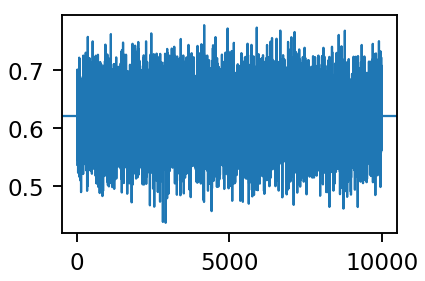

In [38]:
plt.plot(q_lit_abs.params.eval())
plt.axhline(y=true_prob)

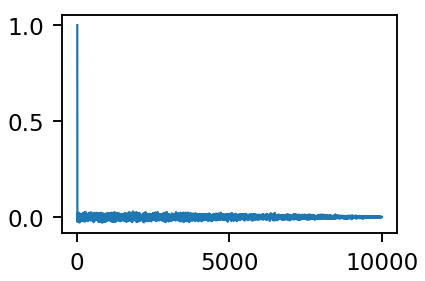

In [39]:
plt.plot(lags(q_lit_abs.params).eval())

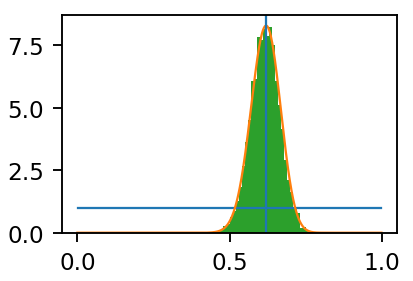

In [40]:
x = tf.range(0.0, 1.0, 0.001)
plt.plot(*sess.run([x, prior.prob(x)]))  # blue flat line
plt.plot(*sess.run([x, cond.prob(x)], {c: lit_abs})) # orange
plt.hist(q_lit_abs.params.eval(), bins=100, range=(0.0, 1.0), normed=True) # green
plt.axvline(x=true_prob) # blue vertical

### MCMC: Hamiltonian Monte Carlo

Metropolis Hastings and Gibbs will fail in high dimensional parameter space while HMC will not

HMC utilizes the geometry of important regions of the posterior to guide the jump proposal. Works only on parameters that are continous. Not discrete.

In [28]:
# Backward Model
T = 10000 # number of empirical examples
q_lit_abs = Empirical(params=tf.Variable(tf.ones([T])*.5))

In [29]:
# Inference
inference = ed.HMC(latent_vars={prior:q_lit_abs}, data={c:lit_abs})
inference.run(step_size=1.0/N, n_steps=20)

10000/10000 [100%] ██████████████████████████████ Elapsed: 22s | Acceptance Rate: 1.000


In [30]:
# Criticism
mean, stddev = sess.run([q_lit_abs.mean(), q_lit_abs.stddev()])
print('Posterior Mean: {0}\nPosterior Std: {1}'.format(mean, stddev))

Posterior Mean: 0.482121676207
Posterior Std: 0.20500703156


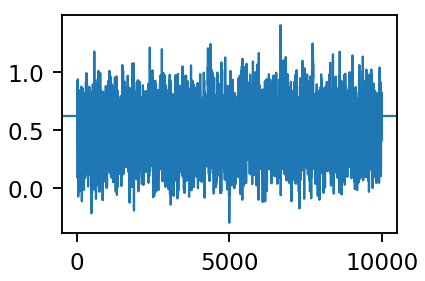

In [31]:
plt.plot(q_lit_abs.params.eval())
plt.axhline(y=true_prob)

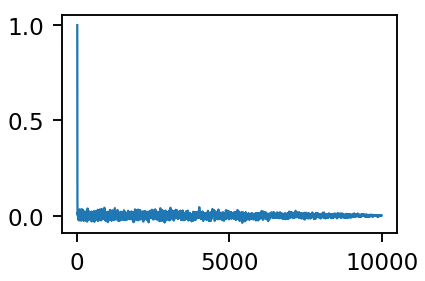

In [32]:
plt.plot(lags(q_lit_abs.params).eval())

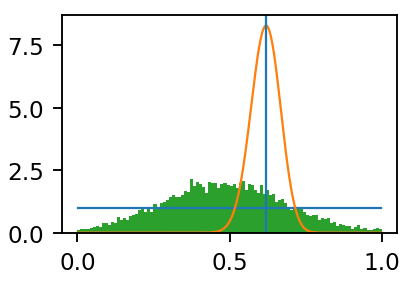

In [34]:
x = tf.range(0.0, 1.0, 0.001)
true_prob = sum(lit_abs==1)/float(lit_abs.shape[0])
plt.plot(*sess.run([x, prior.prob(x)]))  # blue flat line
plt.plot(*sess.run([x, cond.prob(x)], {c: lit_abs})) # orange
plt.hist(q_lit_abs.params.eval(), bins=100, range=(0.0, 1.0), normed=True) # green
plt.axvline(x=true_prob) # blue vertical

## Variational Inference

VI is a class of algorithms that cast posterior inference as optimization

Instead of inferring the posterior parameters, we approximate the Model Parameters, ie, the posterior p(params|data=obs):

    a. Build a variational backward model, q(params;lambda) over the params with some variational parameters of lambda.
    
    b. Match q(params;lambda) to p(params|obs) by optimizing over lambda,
        lambda* = argmin closeness(p(params|obs), q(params;lambda)) over lambda
     
    c. Use q(params; lambda*) instead of p(params|obs)
    
    d. Criticize the variational model, revise it.
    
We use the Kullback-Leibler divergence, KLqp to measure closeness between p(params|obs) and q(params;lambda)

In [41]:
# Backward
q_prior_concentration1 = tf.nn.softplus(tf.Variable(tf.random_normal([])))
q_prior_concentration0 = tf.nn.softplus(tf.Variable(tf.random_normal([])))
q_prior = Beta(concentration1=q_prior_concentration1, concentration0=q_prior_concentration0)

In [43]:
# Inference
inference = ed.KLqp(latent_vars={prior:q_prior}, data={c:lit_abs})
inference.run(n_samples=20, n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: nan


In [44]:
sess.run({k:v for k, v in six.iteritems(q_prior.parameters) if isinstance(v, tf.Tensor)})

{'concentration0': nan, 'concentration1': nan}

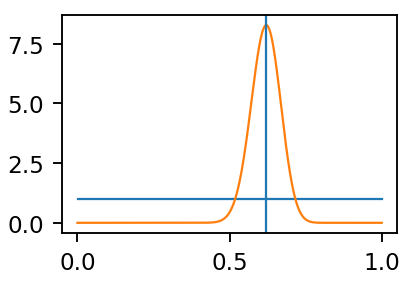

In [45]:
x = tf.range(0.0, 1.0, 0.001)
true_prob = sum(lit_abs==1)/float(lit_abs.shape[0])
plt.plot(*sess.run([x, prior.prob(x)]))  # blue flat line
plt.plot(*sess.run([x, cond.prob(x)], {c: lit_abs})) # orange
plt.plot(*sess.run([x, q_prior.prob(x)])) # orange
# plt.hist(q_lit_abs.params.eval(), bins=100, range=(0.0, 1.0), normed=True) # green
plt.axvline(x=true_prob) # blue vertical

In [46]:
# Criticism
mean, stddev = sess.run([q_lit_abs.mean(), q_lit_abs.stddev()])
print('Posterior Mean: {0}\nPosterior Std: {1}'.format(mean, stddev))

Posterior Mean: 0.5
Posterior Std: 0.0


### Bayesian Linear Regression

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_sub.log_pop, df_sub.OVERALL_LI, test_size=0.25)

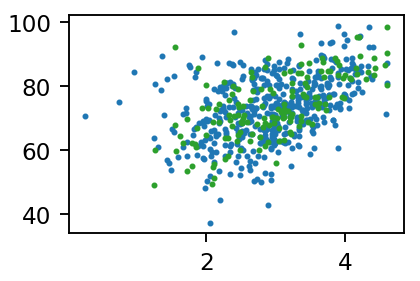

In [8]:
plt.scatter(X_train, y_train, s=20.0);  # blue
plt.scatter(X_test, y_test, s=20.0, color=sns.color_palette().as_hex()[2]);  # red

In [19]:
X_train = np.asarray(X_train).reshape(X_train.shape[0], 1)
X_test = np.asarray(X_test).reshape(X_test.shape[0], 1)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [10]:
from edward.models import Empirical, Normal

In [11]:
# Forward Model
D = 1 # Number of features
N = X_train.shape[0]
x = tf.placeholder(tf.float32, [N, D])
weights = Normal(loc=tf.zeros(D), scale=tf.ones(D))
intercept = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(x, weights) + intercept, scale=tf.ones(N)*0.1)

In [12]:
# Backward Model
T = 10000
q_weights = Empirical(params=tf.Variable(tf.zeros([T, D])))
q_intercept = Empirical(params=tf.Variable(tf.zeros([T, 1])))

In [21]:
X_train.shape

(467, 1)

In [22]:
# Inference
inference = ed.HMC(latent_vars={weights:q_weights, intercept:q_intercept}, data={x:X_train, y:y_train})
inference.run(step_size=0.01/N, n_steps=20)

10000/10000 [100%] ██████████████████████████████ Elapsed: 20s | Acceptance Rate: 0.867


In [35]:
np.linspace(0., 6., 2.)[:, np.newaxis]

/home/a635137/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


array([[0.],
       [6.]])

/home/a635137/.local/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  import sys


ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

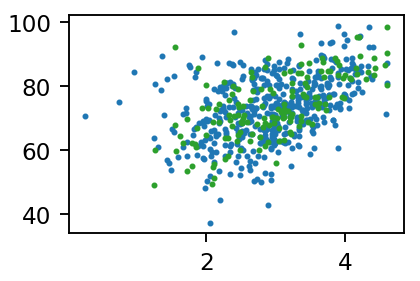

In [38]:
# Criticism
plt.scatter(X_train, y_train, s=20.)
plt.scatter(X_test, y_test, s=20.0, color=sns.color_palette().as_hex()[2])
xp = tf.placeholder(tf.float32, [2, D])
[plt.plot(np.linspace(0, 6, 1), sess.run(ed.dot(xp, q_weights.params[t]) + q_intercept.params[t], 
                                        {xp:np.linspace(0., 6., 2.)[:, np.newaxis]}), color='black', alpha=0.1)
          for t in range(int(T/2), T, int(T/100))]